# ATOC REU Python Bootcamp Day 6
## Multi-dimensional data with xarray, part 2

## Topics for the day
* Review xarray basics 
* Calculate new xarray variables 
* Make simple maps 
* Save a netcdf file from xarray
* Filter data with .where()
* Area-weighted averaging
* Merge datasets together 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

In [2]:
# Import xarray 
import xarray as xr

## Import Data

**Dataset: ECMWF Ocean Reanalysis System 4 (ORAS4)**

* Reanalysis products aim to provide a complete picture of Earth's past weather and climate. Since our observations are limited, we combine them with model outputs to generate continuous space/time fields on a grid. This allows us to estimate past environmental variables at any point on the globe, and at various depths in the ocean or altitudes in the atmosphere.
* Period: 1958-2017
* Resolution: Horizontal 1°x1°, 42 vertical levels, about 10m-15m level thickness in upper 200m.
* For more information, see https://www.cen.uni-hamburg.de/en/icdc/data/ocean/easy-init-ocean/ecmwf-ocean-reanalysis-system-4-oras4.html

In [3]:
# Open dataset from OPeNDAP link
ocean_temp = xr.open_dataset('https://icdc.cen.uni-hamburg.de/thredds/dodsC/oras4_temp_all')

Check xarray variables and dimensions

In [4]:
ocean_temp

<xarray.Dataset>
Dimensions:  (depth: 42, lon: 360, lat: 180, time: 720)
Coordinates:
  * depth    (depth) float32 5.022 15.08 25.16 ... 4.752e+03 5.051e+03 5.35e+03
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * time     (time) datetime64[ns] 1958-01-16 1958-02-14 ... 2017-12-16
Data variables:
    mask     (depth, lat, lon) float32 ...
    thetao   (time, depth, lat, lon) float32 ...
Attributes:
    NCO:                       4.4.6
    nco_openmp_thread_number:  1
    Conventions:               CF-1.1
    title:                     ORAS4 ocean reanalysis
    institution:               ECMWF
    source:                    Interpolated into WOA 1x1 grid and  monthly av...
    references:                http://www.ecmwf.int/products/forecasts/d/char...
    history:                   Tue May 22 09:21:39 2018: ncrename -d dep,dept...

Looking at the metadata, we see that the 'thetao' variable is the sea water potential temperature. Potential temperature removes the effect of pressure on water temperature. Since the differences are small for our purposes, we'll consider it equivalent to the measured temperature. Let's rename this variable to 'temp', so that it's easier for us to remember. 

In [5]:
ocean_temp = ocean_temp.rename({'thetao':'temp'})

# Create Temperature-Depth Transect Plot

This dataset includes all ocean depth levels! Let's look at how temperature varies with depth and latitude in the Atlantic Ocean. Which line of longitude should we select? Run the cell below to create a simple world map.

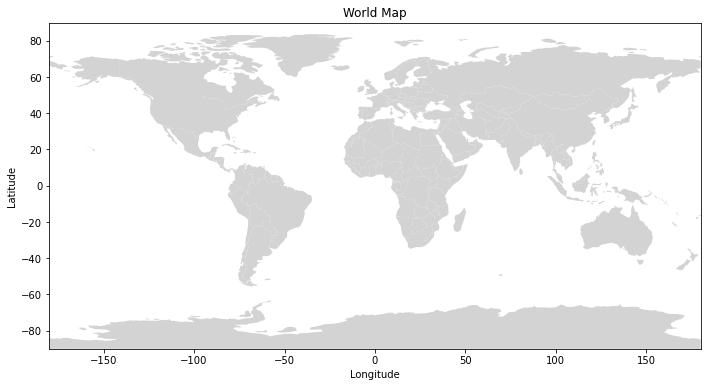

In [6]:
# From GeoPandas, our world map data
worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# Creating axes and plotting world map
fig, ax = plt.subplots(figsize=(12, 6))
worldmap.plot(color="lightgrey", ax=ax)

# Creating axis limits and title
plt.xlim([-180, 180])
plt.ylim([-90, 90])
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title('World Map')
plt.show()

-25 seems to be a good line of longitude that will cut through the middle of the Atlantic without running into continents. The only issue is that our xarray dataset has longitude coordinates from 0 to 360 degrees. Let's convert our coordinates to -180 to 180 degrees so that it's easier to select -25.

In [7]:
# Convert coordinates from 0:360 to -180:180
ocean_temp.coords['lon'] = (ocean_temp.coords['lon'] + 180) % 360 - 180
ocean_temp = ocean_temp.sortby(ocean_temp.lon)

Now let's plot our meridional (north/south) cross section. We'll select the most recent time step in the dataset by writing `.isel(time=-1)`.

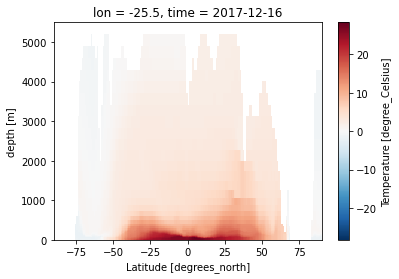

In [8]:
ocean_temp.isel(time=-1).sel(lon=-25.5).temp.plot()

How can we make this plot easier to interpret?

Since this is a 3-dimensional dataset, the `.plot()` function calls `xarray.plot.pcolormesh`. See the documentation [here](https://docs.xarray.dev/en/stable/generated/xarray.plot.pcolormesh.html#xarray.plot.pcolormesh) to see the parameters that we can change.

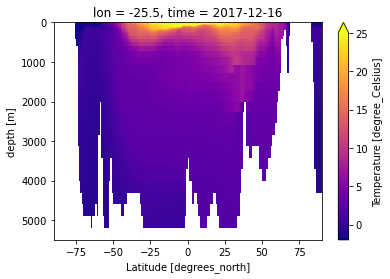

In [9]:
ocean_temp.isel(time=-1).sel(lon=-25.5).temp.plot(vmin=-2, vmax=25, yincrease = False, cmap='plasma')

Over the next 5 minutes in the cells below, make a few more plots like the one above but this time with the zonal (east/west) mean instead of the meridional mean. Remember that each latitude is defined at the center point, so you will need to add 0.5 when selecting. Try playing around with different colorbars ('cmap'), and values of 'vmin' and 'vmax', so that your figures are as clear as possible. To see other colorbar options, go here: https://matplotlib.org/stable/tutorials/colors/colormaps.html.

Lat = 0:

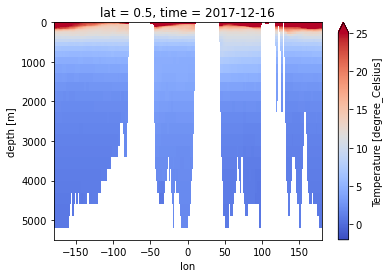

In [10]:
# Your answer: 
ocean_temp.isel(time=-1).sel(lat=0.5).temp.plot(vmin=-2, vmax=25, yincrease = False, cmap='coolwarm')

Lat = 30:

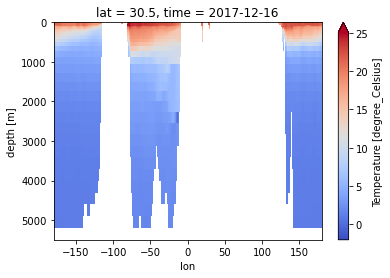

In [11]:
# Your answer:
ocean_temp.isel(time=-1).sel(lat=30.5).temp.plot(vmin=-2, vmax=25, yincrease = False, cmap='coolwarm')

Lat = 80:

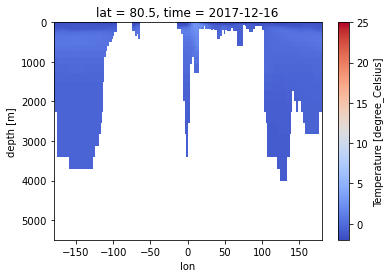

In [12]:
# Your answer: 
ocean_temp.isel(time=-1).sel(lat=80.5).temp.plot(vmin=-2, vmax=25, yincrease = False, cmap='coolwarm')

Discussion: what features do we see?

# SST analysis

Fill in the the the parenthesis to select the first depth in the dataset. Then select the variable 'temp'

In [13]:
# Answer: 
ocean_sst = ocean_temp.isel(depth = 0).temp

### Make a map of SST climatology

Take the mean over all time steps 

In [15]:
# This requires a lot of calculations, so it will take a couple minutes to run
sst_climo = ocean_sst.mean(dim='time')

In [ ]:
sst_climo

Now, let's make a map! Looking at `ocean_sst_mean`, we see that is is a DataArray with two dimensions: lat and lon. Therefore, we can make a map using the same function that we used above: `.plot()`.

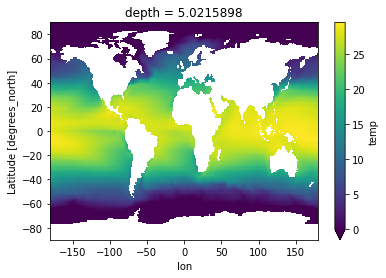

In [18]:
sst_climo.plot(vmin=0)

In [19]:
# Save output as a netcdf (we will use this for the challenge later)
sst_climo.to_netcdf('sst_climatology_oras4.nc')

Now take the mean over the entire globe:

In [20]:
sst_climo_global = sst_climo.mean()

In [21]:
sst_climo_global

<xarray.DataArray 'temp' ()>
array(13.77875, dtype=float32)
Coordinates:
    depth    float32 5.022

### Plot temperature anomaly over time

Take the annual average. How will the output of the cell below be different from the previously calculated `ocean_sst_climo`?

In [22]:
sst_annual = ocean_sst.groupby('time.year').mean('time')

In [23]:
# Your answer:
sst_annual_global = sst_annual.mean(dim=['lat', 'lon'])

Now we can subtract the climatology from the annual mean. If a year is warmer than normal, will the value be positive or negative?

In [25]:
sst_annual_anom = sst_annual_global - sst_climo_global

Text(0, 0.5, 'Temperature Anomaly (°C)')

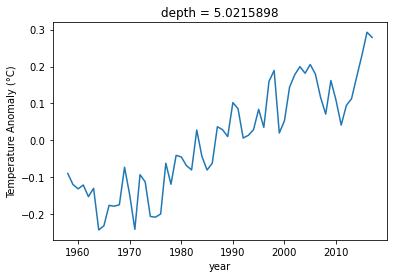

In [26]:
sst_annual_anom.plot()
# Change the y-axis label to make it clear that we are plotting the anomaly
plt.ylabel("Temperature Anomaly (°C)")

## Where is temperature increasing at the greatest rate?

To calculate the linear trend, we'll use the [xarray polyfit function](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.polyfit.html).

In [27]:
sst_trends = sst_annual.polyfit(dim = 'year', deg = 1) 

In [28]:
sst_trends = sst_trends.sel(degree = 1)

In [29]:
sst_trends.plot()

ValueError: Dataset.plot cannot be called directly. Use an explicit plot method, e.g. ds.plot.scatter(...)

Why doesn't this work? Remember that `.plot()` only works with DataArrays. Even though our Dataset only has one data variable, we need to explicitly call it in order to create the plot. 

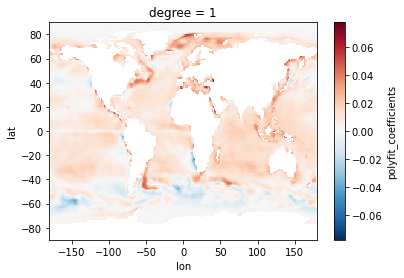

In [30]:
sst_trends.polyfit_coefficients.plot()

### Are all depths warming the same amount?

At one lat/lon point, make a plot of mean temperate as a function of depth and year. 

In [31]:
# Select a point in the North Atlantic
depth_temp_trend = ocean_temp.sel(lat=70.5, lon=-10.5).temp

In [32]:
# Take the annual mean
depth_temp_trend = depth_temp_trend.groupby('time.year').mean('time')

Now, try making the plot.

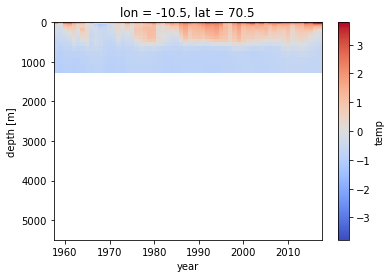

In [33]:
# Your answer: 
depth_temp_trend.plot(y='depth', yincrease = False, cmap='coolwarm')

Here is makes sense to manually adjust the length of the yaxis using 'ylim' so that we aren't showing depths deeper than the ocean at that location. Set 'ylim' to the ocean depth at this point.

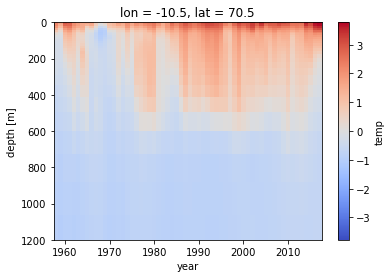

In [34]:
# Your answer: 
depth_temp_trend.plot(y='depth', yincrease = False, cmap='coolwarm', ylim = 1200)

## Calculate average temperature within ocean regions

First, we need to select our region of interest. Using `xr.where()`, let's select all grid cells between 45:60 in latitude and -50:-10 in longitude. We can visualize this bounding box on a map using the `worldmap` data we imported from geopandas earlier. 

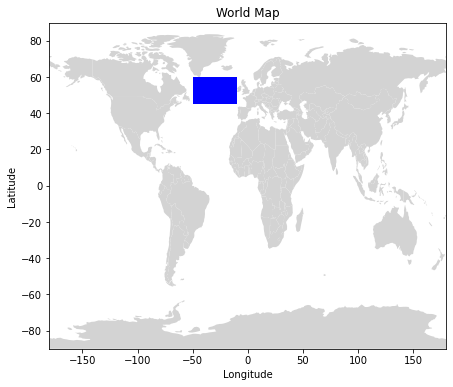

In [35]:
from shapely.geometry import Polygon
region = gpd.GeoDataFrame({'geometry': [Polygon([(-50, 45), (-50, 60), (-10, 60), (-10, 45)])]}, crs="EPSG:4326")

# Creating axes and plotting world map
fig, ax = plt.subplots(figsize=(12, 6))
worldmap.plot(color="lightgrey", ax=ax)
region.plot(color='blue', ax=ax)

# Creating axis limits and title
plt.xlim([-180, 180])
plt.ylim([-90, 90])
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title('World Map')
plt.show()

In [36]:
north_atlantic = ocean_sst.where(np.logical_and(ocean_sst.lat>45, ocean_sst.lat<60), drop = True).where(np.logical_and(ocean_sst.lon>-50, ocean_sst.lon<-10), drop = True)

In [ ]:
north_atlantic

How have the dimensions of our DataArray changed? Let's select the first time step and make a simple map to see the new spatial extent of our data.

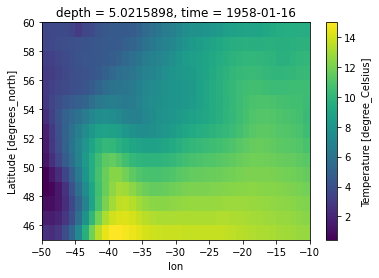

In [38]:
north_atlantic.isel(time=0).plot()

Now, calculate the regional mean and plot a timeseries. 

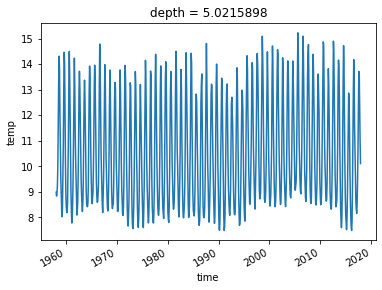

In [39]:
north_atlantic.mean(dim=['lat', 'lon']).plot()

Sometimes our region of interest can't be defined simply by a bounding lat/lon box. For example, if we were using an atmospheric dataset, we may want to look at temperature values within the United States or only in the Rocky Mountains. If we have another dataset defining our region of interest, we can easily filter our data using the `.where()` function again!

Here, we import an ocean biomes dataset. Similar to biomes on land, ocean biomes are defined by certain climate conditions that give rise to unique ecosytems. The ocean biomes here were determines using sea surface temperature, spring/summer chlorophyll-a concentrations, ice fraction, and maximum mixed layer depth. (Fay, A. R. and McKinley, G. A.: Global open-ocean biomes: mean and temporal variability, Earth Syst. Sci. Data, 6, 273–284, https://doi.org/10.5194/essd-6-273-2014, 2014.)

In [40]:
biomes = xr.open_dataset('Time_Varying_Biomes.nc')

Xarray has no inherent knowledge of geographic coordinates. So we need to flip the x and y coordinates with the `.transpose()` function to make a recognizable map.

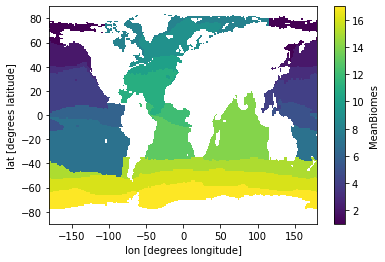

In [41]:
biomes.MeanBiomes.transpose().plot()

Fortunately, this dataset is on the same grid as our climatology dataset. To merge these two datasets, we can simply set a new 'biomes' variable to our existing dataset like this: 

In [42]:
ocean_sst['biomes'] = biomes.MeanBiomes

Now we can select our regions of interest (where the biomes dataset is equal to 8 and 9).

In [43]:
north_atlantic_sst = ocean_sst.where(biomes.MeanBiomes.isin([8,9]), drop = True)

Select a time range (1960-1980): 

(array([3.16718e+05, 1.03246e+05, 9.48260e+04, 9.19070e+04, 7.97080e+04,
        4.64350e+04, 2.12000e+04, 5.70200e+03, 1.02400e+03, 2.10000e+02]),
 array([-1.9234289,  0.6504112,  3.2242513,  5.7980914,  8.371931 ,
        10.945771 , 13.519611 , 16.093452 , 18.667292 , 21.241133 ,
        23.814972 ], dtype=float32),
 <BarContainer object of 10 artists>)

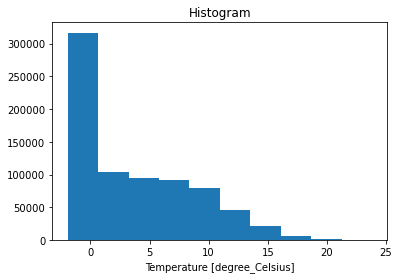

In [44]:
north_atlantic_sst.sel(time=slice('1960-01-01','1979-12-01')).plot()

Why do we get a histogram instead of a map here?

We have multiple time steps! To make maps, we can either take the mean, or make make column faceted plots. First, let's calculate the mean. Complete the code below to calculate the mean over the time dimension, and create a simple map.

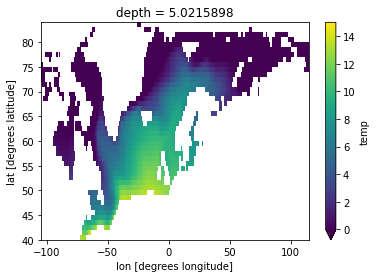

In [45]:
# Your answer: 
north_atlantic_sst.sel(time=slice('1960-01-01','1979-12-01')).mean(dim='time').plot(vmin = 0, vmax = 15)

Taking the mean removes a lot of information. For example, how does the temperature in this region vary seasonally? To investigate this, let's look at one year of data and make column faceted plots. Here we specify that we want to plot each timestep in separate columns by setting `col = 'time'`. The `col_wrap` parameter specifies how many columns we want.

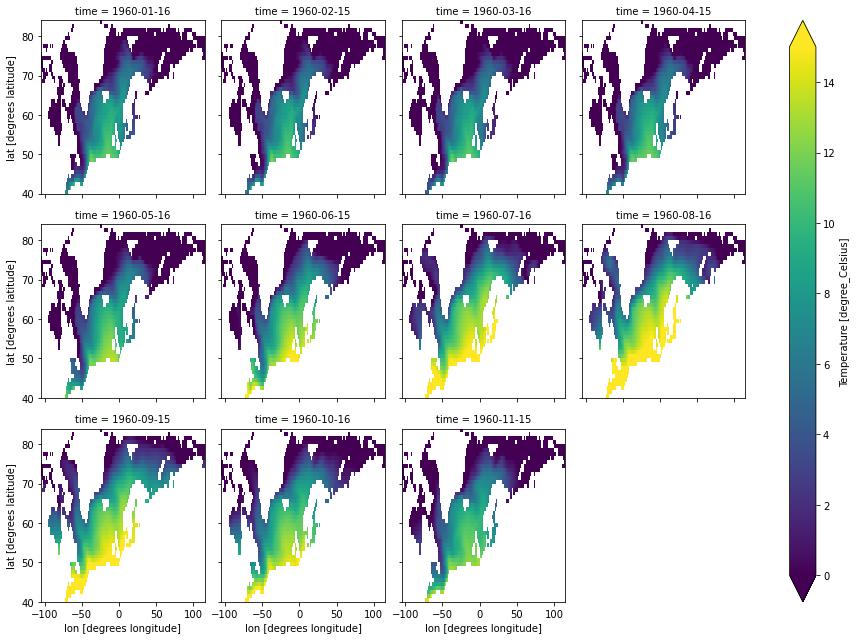

In [46]:
north_atlantic_sst.sel(time=slice('1960-01-01','1960-12-01')).plot(col = 'time', col_wrap = 4,
                                                                  vmin = 0, vmax = 15)

Now let's make a timeseries plot of temperature, taking the mean over the entire region. 

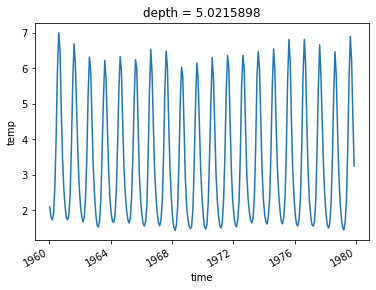

In [47]:
north_atlantic_sst.sel(time=slice('1960-01-01','1979-12-01')).mean(dim=['lat', 'lon']).plot()

What is the overall mean for this region over all time steps and lat/lon?

In [48]:
north_atlantic_sst.mean()

<xarray.DataArray 'temp' ()>
array(3.6691902, dtype=float32)
Coordinates:
    depth    float32 5.022

### Calculate area-weighted average

Since lines of longitude converge at the poles, the total area within a 1x1 degree cell decreases with increasing latitude. So our grid cells at the equator cover much more physical space than cells near the poles. To avoid biases when calculating spatial averages, we need to weight each grid cell according to its actual area. We can do this easily by taking the cosine of the latitude. We can see in the plot below that the weight of each grid cell decreases as we move poleward to account for smaller cells. 

In [49]:
# Area weight
area_weights = np.cos(np.deg2rad(north_atlantic_sst.lat))
area_weights.name = "area weights"

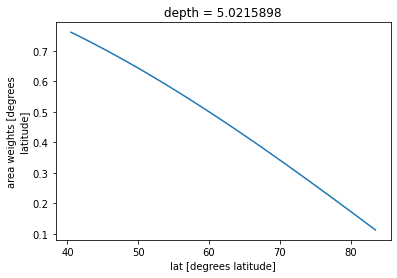

In [50]:
area_weights.plot()

Notice how the area weights decrease as latitude increases. Now let's take the average again, applying the area weights. To do this, we can use the xarray [weighted function](https://docs.xarray.dev/en/v2022.03.0/generated/xarray.DataArray.weighted.html).

In [51]:
north_atlantic_sst.weighted(area_weights).mean()

<xarray.DataArray 'temp' ()>
array(5.12873679)
Coordinates:
    depth    float32 5.022

How does this compare to the value we calculated previously?
What about our time series plot? Let's see if that changes at all when we apply the area weights.

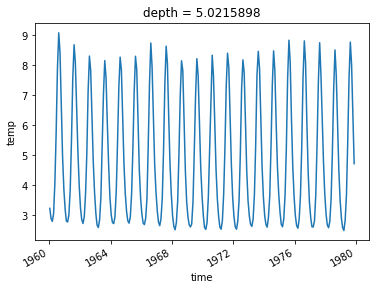

In [52]:
north_atlantic_sst.sel(time=slice('1960-01-01','1979-12-01')).weighted(area_weights).mean(dim=['lat', 'lon']).plot()

Our mean value is now much warmer that what we calculated without the area weights. This makes sense becuase the grid cells closer to the poles are artifically large. 

# Conclusion 
We're now done with the lecture portion of today! We hope that you are now comfortable working with multidimensional datasets in xarray. But we know it's complicated, so don't worry if you are still feeling a little lost. As you move on to the challenge activity, and later to your future research, here are some useful links to xarray documentation and tutorials. 

**Helpful resources:**
* Xarray documentation: https://xarray.pydata.org/en/v0.7.1/index.html or https://docs.xarray.dev/en/stable/index.html
* Pangeo Gallery: http://gallery.pangeo.io/repos/pangeo-data/pangeo-tutorial-gallery/xarray.html
* Earth Lab Tutorials: https://www.earthdatascience.org/tutorials/
* Earth and Environmental Data Science Book: https://earth-env-data-science.github.io/lectures/xarray/xarray_intro.html